In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Fri Mar  5 14:47:47 PST 2021


In [2]:
# ## TODO

# pull sdi and other missing covariates

# shift, logit transform pct pop eating vehicle
# impute missing vals for logical set of covariates (watch for covariance)
# run a linear regression by vehicle

# use outputs to predict pct pop eating vehicle / pct pop eating ind prod vehicle, shifted and logit transformed

# then finally ind prod / fortified, same method

# --- 

# updates and adjustments can include gradient boosting and throwing in more/all covariates
# clipping as opposed to shifted logit


In [3]:
# data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_data_estimated.csv'
# df = pd.read_csv(data_path)

df = pd.read_csv('test_add_gbd_covs.csv')
df = df.drop(columns=['standard'])
df.columns = [i.replace(" ","_") for i in df.columns]

In [4]:
fao_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/FAOSTAT_food_supply_aggregated_oil_2018.csv'
fao = pd.read_csv(fao_path)

In [5]:
fao.loc[(fao.location_name=="Viet Nam"),'location_name'] = "Vietnam"

In [6]:
df = df.merge(fao, on = 'location_name', how = 'left')

In [7]:
df.head()

,location_name,vehicle,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
0,Angola,wheat flour,iron,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
1,Angola,wheat flour,zinc,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
2,Angola,wheat flour,folic acid,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
3,Angola,wheat flour,vitamin b12,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0
4,Angola,wheat flour,vitamin b1,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0


In [8]:
from scipy.special import logit, expit

In [9]:
def shift_logit(df, cols, shift = .1):
    """
    shifts non-NaN vals in df[cols] up by 'shift' percents, then logit transforms 
    """
    transf = df.copy()
    transf[cols] = logit((transf[cols] + shift) / 100)
    
    return transf


def inv_transform(df, cols, shift = .1):
    """
    backtransforms a shifted logit tranformed df[cols]
    """
    inv = df.copy()
    inv[cols] = (expit(inv[cols]) + shift) * 100
    
    return inv

In [10]:
df = shift_logit(df, ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle'])

In [11]:
def guess_mean_val(df, grouped_on, cols):
    c = df.copy()
    
    mean_cols = c.groupby(grouped_on).transform('mean')[cols]
    mean_cols.columns = [f'mean_{i}' for i in mean_cols.columns]
    
    c[mean_cols.columns] = mean_cols
    
    for col in cols:
        c.loc[(c[col].isna()),col] = c[f'mean_{col}']
    
    return c.drop(columns = mean_cols.columns)

# def guess_mean_val(df, cols):
#     c = df.copy()
#     for col in cols:
#         m = c[col].mean()
#         c.loc[(c[col].isna()),col] = m
#     return c

In [12]:
eats_wheat = df[(df.vehicle=="wheat flour")]

In [13]:
eats_wheat = guess_mean_val(eats_wheat, grouped_on = 'vehicle', cols = ['percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'location_id',
       'sodium', 'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all'])

In [14]:
eats_wheat

,location_name,vehicle,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
0,Angola,wheat flour,iron,NaN,-0.877985,-3.734097,168,0.981117,8.870610,0.464635,0.805634,415.0,80.0,256.0,282.0
1,Angola,wheat flour,zinc,NaN,-0.877985,-3.734097,168,0.981117,8.870610,0.464635,0.805634,415.0,80.0,256.0,282.0
2,Angola,wheat flour,folic acid,NaN,-0.877985,-3.734097,168,0.981117,8.870610,0.464635,0.805634,415.0,80.0,256.0,282.0
3,Angola,wheat flour,vitamin b12,NaN,-0.877985,-3.734097,168,0.981117,8.870610,0.464635,0.805634,415.0,80.0,256.0,282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Madagascar,wheat flour,vitamin a,NaN,-0.877985,-3.734097,181,1.084350,16.192304,0.400606,0.745390,66.0,1075.0,105.0,72.0
344,Myanmar,wheat flour,vitamin a,-2.923583,0.004000,-6.906755,15,2.274897,23.833147,0.531769,0.845467,43.0,1221.0,69.0,190.0
346,Niger,wheat flour,vitamin a,NaN,-0.877985,-3.734097,213,0.788394,6.611979,0.170386,0.606974,24.0,181.0,26.0,96.0
348,Pakistan,wheat flour,vitamin a,3.636560,-0.049343,-6.906755,165,1.427600,1.228010,0.475739,0.748086,164.0,138.0,920.0,278.0


In [15]:
from scipy.special import logit, expit

In [16]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

In [19]:
df_numeric = eats_wheat.copy()
df_numeric['location_name'] = df_numeric.location_name.map(loc_map)
df_numeric['vehicle'] = df_numeric.vehicle.map(vcl_map)
df_numeric['nutrient'] = df_numeric.nutrient.map(nut_map)

In [20]:
X_full = np.array(df_numeric.drop(columns='percent_of_population_eating_vehicle'))

y_full = np.array(df_numeric.percent_of_population_eating_vehicle)

y = y_full[~np.isnan(y_full)]

X = X_full[~np.isnan(y_full)]

In [24]:
# randomly hold out a selection
N = y.shape[0]
select = np.random.choice(N, size = N - (N // 4), replace = False)

In [25]:
reg = LinearRegression().fit(X[select], y[select])

In [26]:
holdout = np.array([i for i in range(N) if i not in select])

preds = reg.predict(X[holdout])

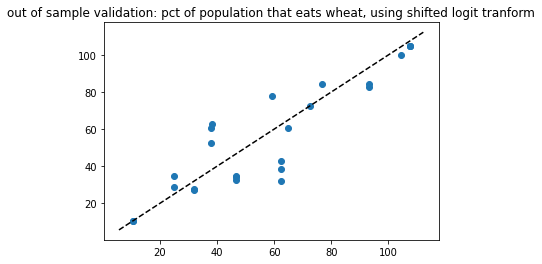

In [28]:
backtransf_preds = (expit(preds) + .1) * 100
backtransf_y = (expit(y[holdout]) + .1) * 100

plt.scatter(backtransf_y, backtransf_preds)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.title("out of sample validation: pct of population that eats wheat, using shifted logit tranform")
plt.plot([lb, ub], [lb, ub], 'k--')

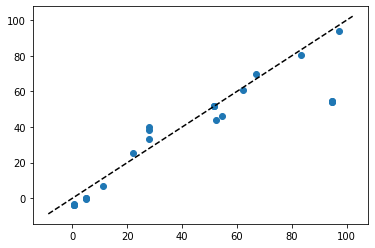

In [99]:
plt.scatter(y[holdout], preds)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)

plt.title("out of sample validation: pct of population that eats wheat")
plt.plot([lb, ub], [lb, ub], 'k--')

In [ ]:
df_numeric.head()

In [15]:
df_numeric.groupby('vehicle').count()

,location_name,nutrient,percent of population eating vehicle,percent of population eating industrially produced vehicle,percent of population eating fortified vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
vehicle,,,,,,,,,,,,,,
0,6,6,2,4,5,6,6,6,6,6,6,6,6,6
1,102,102,48,48,48,102,102,102,102,102,96,96,96,96
2,150,150,102,102,105,150,150,150,150,150,138,138,138,138
3,28,28,12,4,16,28,28,28,28,28,24,24,24,24
4,50,50,36,22,35,50,50,50,50,50,46,46,46,46
5,15,15,10,10,10,15,15,15,15,15,15,15,15,15


In [16]:
df_numeric.columns = [i.replace(" ","_") for i in df_numeric.columns]

In [17]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']

In [18]:
for var in estimation_vars:
    print(f'{df_numeric[var].isnull().sum()}/{len(df_numeric)} missing for {var}')

141/351 missing for percent_of_population_eating_vehicle
161/351 missing for percent_of_population_eating_industrially_produced_vehicle
132/351 missing for percent_of_population_eating_fortified_vehicle


In [19]:
## create a version with holdouts
df_partial = df_numeric.copy()
for _ in range(len(df_numeric)*3 // 6):
    j = np.random.choice(estimation_vars)
    i = np.random.choice(df.index[df_partial[j].notnull()])
    df_partial.loc[i,j] = np.nan

In [20]:
for var in estimation_vars:
    print(f'{df_partial[var].isnull().sum()}/{len(df_partial)} missing for {var}')

204/351 missing for percent_of_population_eating_vehicle
220/351 missing for percent_of_population_eating_industrially_produced_vehicle
185/351 missing for percent_of_population_eating_fortified_vehicle


In [21]:
from statsmodels.imputation import mice

In [22]:
imp = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_partial)

In [ ]:
%%time
N = 5
df_imputed = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp.update_all(n_iter=100)
    df_imputed[r] = imp.data

. 

In [ ]:
# let's see if we can improve with some covariates?
for col in estimation_vars:
    for df_i in df_imputed.values():
        rows = df_partial[col].isnull() & df_numeric[col].notnull()
        plt.plot(df_numeric.loc[list(rows), col], df_i.loc[list(rows), col], '.', alpha=.5)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.plot([lb, ub], [lb, ub], 'k--')

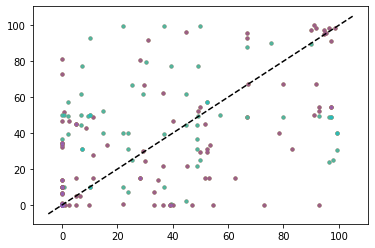

In [28]:
# let's see if we can improve with some covariates?
for col in estimation_vars:
    for df_i in df_imputed.values():
        rows = df_partial[col].isnull() & df_numeric[col].notnull()
        plt.plot(df_numeric.loc[list(rows), col], df_i.loc[list(rows), col], '.', alpha=.5)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.plot([lb, ub], [lb, ub], 'k--')

# what happens when we use all data?

In [29]:
imp_full = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_numeric)

In [30]:
%%time
N = 5
df_imputed_full = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp_full.update_all(n_iter=100)
    df_imputed_full[r] = imp.data

. . . . . CPU times: user 1min 14s, sys: 60.5 ms, total: 1min 14s
Wall time: 1min 14s


In [31]:
# checkout performance

In [32]:
# does imp remember prev iters? should df_imputed[i+1] be 'better' than df_imputed[i]?
# did they all do the same?

In [33]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_vehicle <
                  df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle)].shape[0])

94
94
94
94
94


In [34]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle <
                  df_imputed_full[i].percent_of_population_eating_fortified_vehicle)].shape[0])

32
32
32
32
32
